In [1]:
import numpy as np
import pandas as pd
import sentence_transformers
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import bertopic
import spacy
from transformers import pipeline
import string
from nltk.stem import PorterStemmer

In [2]:
df_news = pd.read_json('data/cc_gw_news_blogs_2021-10-01_2021-10-31.json')

# Text cleaning and searching

First, count the number of unique words in the titles of all articles in the dataframe.

In [3]:
## Extract all titles, and make a single long string from them.
titles = ' '.join(df_news.title.values)
## Remove all punctuation.
titles = titles.translate(str.maketrans('','',string.punctuation))
## Apply stemming to the words - note this is optional depending on your personal definition of a word.
ps = PorterStemmer()
titles = [ps.stem(w) for w in titles.split()]
## Converting to a set keeps only unique words, which we then count.
print(f'There are {len(set(titles))} unique words in all titles.')

There are 45391 unique words in all titles.


Which is the most common form of the root word `talk` in the titles? Hint: you may find the `collections` library useful.

In [4]:
import collections
## Extract all titles, and make a single long string from them.
titles = ' '.join(df_news.title.values)
## Remove all punctuation.
titles = titles.translate(str.maketrans('','',string.punctuation))
titles = titles.lower().split()
## Apply stemming to the words.
titles_stemmed = [ps.stem(w) for w in titles]

## Now we have lists of raw and stemmed words.
talk_fulls = []
for full, stem in zip(titles,titles_stemmed):
    if stem == 'talk':
            talk_fulls.append(full)
talk_count = collections.Counter(talk_fulls)
print(talk_count)

Counter({'talks': 2704, 'talk': 744, 'talking': 115, 'talked': 7})


How many of the headlines mention Justin Trudeau?

In [5]:
## We'll consider a headline as relevant if it mentions just his surname.
count = 0
for t in df_news.title:
    if 'trudeau' in t.lower():
        count += 1
print(f'{count} titles mention Trudeau.')

640 titles mention Trudeau.


How many of the headlines mention one of the G7 countries?

In [6]:
## This query is not an exhaustive list - you could do more to match the UK and US.
query = r'(Canada|Italy|France|Germany|Japan|United Kingdom|UK|United States|US|)'
count = 0
for t in df_news.title:
    if np.any([m != '' for m in re.findall(query,t)]):
        count += 1
print(f'{count} titles mention a G7 country.')

13637 titles mention a G7 country.


How many of the articles reference one of the Conference of Parties (COP) events (in both headlines and bodies)?

In [7]:
query = r'(cop\d+)|(conference of parties \d+)'  ## Note this is more complex than is strictly necessary, matching on "cop" or "conference of parties" would probably suffice, but does
## ensure that we don't match erroneous words like "cope".
title_mask = [np.any([m != '' for m in re.findall(query,t.lower())]) for t in df_news.title]
body_mask = [np.any([m != '' for m in re.findall(query,t.lower())]) for t in df_news.body]
relevant_articles = df_news[[t or b for t,b in zip(title_mask,body_mask)]]  ## This Boolean filter ensures we don't count any article that matches the title and body twice.

print(f'{len(relevant_articles)} reference a COP event.')

39668 reference a COP event.


# Vectorisation and embeddings

Find the five most similar headline among the first 1000 headlines to the provided text.

In [8]:
sentence_model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')

ref_text = ['President Biden visited other G7 leaders in London']
sents = ref_text + [t for t in df_news.title[:1000]]
embs = sentence_model.encode(sents,show_progress_bar=True)

## We can calculate pairwise similarity easily.
sim = cosine_similarity(embs)
## The first row gives the similarity scores we care about. Find the maximal elements.
matches = np.argsort(sim[0])
for i in matches[-6:-1]:
    print(sents[i],sim[0,i])

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

The absence of key world leaders hangs over Biden's first G-20 0.47943187
Biden reflects on American leadership, progress made at G-20 summit 0.4837181
Biden reflects on American leadership, progress made at G-20 summit 0.4837181
Biden reflects on American leadership, progress made at G-20 summit 0.4837181
Biden reflects on American leadership, progress made at G-20 summit 0.4837181


Which of the first 1000 articles uses *climate* the most?

In [9]:
vectorizer = CountVectorizer(stop_words='english')
X_1k = vectorizer.fit_transform([t for t in df_news.body[:1000]])

## We need to get the feature names from vectorizer to find out which column of X_1k to check.
clim_col = list(vectorizer.get_feature_names_out()).index('climate')

max_doc = np.argmax(X_1k[:,clim_col])
print(f'The {max_doc}th article uses climate {X_1k[max_doc,clim_col]} times')

The 576th article uses climate 159 times


# Topic modelling

Fit a topic model over the first 1000 article bodies using the default BERTopic settings. Find the list of row numbers in the dataset that are about the president of Zimbabwe according to the topic model.

In [10]:
topic_model = bertopic.BERTopic()
topics, probs = topic_model.fit_transform(df_news.body[:1000])
df_topics = topic_model.get_topic_info()
df_topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,187,-1_the_of_and_to,"[the, of, and, to, in, that, is, on, for, with]","[Dr. Hoesung Lee, chair of the IPCC (Intergove..."
1,0,104,0_the_of_and_in,"[the, of, and, in, to, climate, is, that, on, ...",[More than three decades have passed since for...
2,1,74,1_g20_trudeau_to_for,"[g20, trudeau, to, for, said, leaders, was, by...",[Canada wanted a stronger and more ambitious a...
3,2,47,2_he_biden_pope_his,"[he, biden, pope, his, francis, knew, the, my,...",[A visibly moved President Joe Biden on Sunday...
4,3,46,3_the_to_g20_countries,"[the, to, g20, countries, of, that, and, for, ...",[ROME (AP) - Leaders of the world's biggest ec...
5,4,38,4_to_the_will_climate,"[to, the, will, climate, and, johnson, in, of,...",[Prime Minister will warn it is 'one minute to...
6,5,37,5_biden_he_said_his,"[biden, he, said, his, about, pump, to, produc...",[President Biden said on Sunday that the world...
7,6,34,6_and_we_the_of,"[and, we, the, of, to, our, vaccines, in, glob...","[ROME, Oct. 31 (Xinhua) -- The 16th Group of 2..."
8,7,32,7_to_and_the_of,"[to, and, the, of, stuff, in, new, for, is, will]",[Related video: The Government commits a massi...
9,8,29,8_to_countries_climate_and,"[to, countries, climate, and, action, change, ...","[Humanity has ""run down the clock"" on climate ..."


In [11]:
## Note the that the topic label here is dependent on a particular iteration of the topic model (unless you fix the random state)
## The topic number should be around 25 in most cases however.
print(f'Row ids corresponding to the president of Zimbabwe are: {[i for i,t in enumerate(topics) if t == 25]}')

Row ids corresponding to the president of Zimbabwe are: [2, 25, 110, 248, 364, 500, 575, 596, 597, 698, 842, 856]


The topics and probabilities assigned by BERTopic correspond to the best fit. Using the probabilities return for each text assigned to the topics in your previous model, find the topics with the highest and lowest mean probability. Do these values tell you anything about the topics highlighted?

In [12]:
## First we convert topics and probs to a more convenient format.
## This gives a list of probabilities for each topic label.
topic_probs = {}
for t,p in zip(topics,probs):
        if not topic_probs.get(t):
            topic_probs[t] = []
        topic_probs[t].append(p)

## Next we average them and record the maximum and minimum we've seen.
max_avg_topic = -2
min_avg_topic = -2
max_avg = 0
min_avg = 1
for t in topic_probs:
    avg = np.mean(topic_probs[t])
    if avg > max_avg:
        max_avg_topic = t
        max_avg = avg
    if avg < min_avg:
        min_avg_topic = t
        min_avg = avg

## This is almost certainly going to be topic -1 with probability 0 - BERTopic doesn't record probabilities for the junk topic.
## This is because they don't really make sense.
print(f'The topic with lowest average probability is {min_avg_topic} with probability {min_avg}.')
## This is probably one of the smaller topics with a very high probability. Be careful of overfitting to duplicate or
## very similar texts in your dataset causing the model to converge anomalously.
print(f'The topic with highest average probability is {max_avg_topic} with probability {max_avg}.')

The topic with lowest average probability is -1 with probability 0.0.
The topic with highest average probability is 25 with probability 0.9983133761515558.


# Text classification

Find the 10 most common entities across the first 1000 articles. Hint: you may find the `collections` library useful.

In [13]:
import collections
import tqdm  ## This displays a progress bar to track efficiency.

nlp = spacy.load("en_core_web_sm")

ents = []
docs = []
for i, row in tqdm.tqdm(df_news[:1000].iterrows()):
    doc = nlp(row.body)
    docs.append(doc)  ## Saving these to avoid repeating the calculation.
    ents += [e.text for e in doc.ents]  ## Note that taking the text is required, otherwise the entities will not be matched.
ent_counts = collections.Counter(ents)
print(f'The ten most common entities are {ent_counts.most_common(10)}.')

1000it [04:27,  3.73it/s]

The ten most common entities are [('Biden', 2169), ('Glasgow', 1694), ('G20', 1660), ('Rome', 1533), ('China', 1340), ('Sunday', 1130), ('U.S.', 935), ('G-20', 776), ('Paris', 686), ('first', 646)].


Different part of speech tags will appear with different frequencies. Find the articles among the first 1000 articles that that have the highest and lowest proportion of proper nouns in their bodies.

In [14]:
max_prop = 0
min_prop = 1
max_prop_id = -1
min_prop_id = -1

for i,doc in enumerate(docs):
    pns = 0
    for t in doc:
        if t.pos_ == 'PROPN':
            pns += 1
    prop = pns/len(doc)
    
    if prop > max_prop:
        max_prop = prop
        max_prop_id = i
    if prop < min_prop:
        min_prop = prop
        min_prop_id = i

print(f'Article {min_prop_id} has the lowest proportion of proper nouns: {min_prop}.')
print(f'Article {max_prop_id} has the lowest proportion of proper nouns: {max_prop}.') 

Article 858 has the lowest proportion of proper nouns: 0.001976284584980237.
Article 371 has the lowest proportion of proper nouns: 0.7074380165289256.


News media is sometimes criticised as focused on negative stories. How are the sentiment labels and class probabilities split over the first 1000 headlines? Does this trend tell you anything about the classes or your chosen model?

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Proportion of positive headlines: 0.115
Proportion of neutral headlines: 0.712
Proportion of negative headlines: 0.173


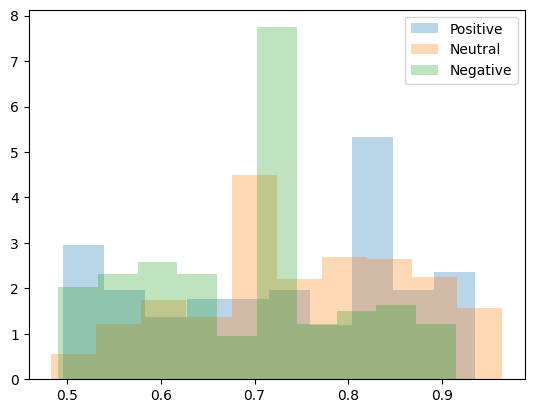

In [15]:
import matplotlib.pyplot as plt
## The example model used earlier in these notes doesn't give a range of sentiment scores and rarely assigns neutral.
## Instead it gives a positive or negative label with a probability of being positive or negative.
## We should use a different model - the Cardiff NLP group is a good source.

sentiment_analysis = pipeline("sentiment-analysis",model="cardiffnlp/twitter-roberta-base-sentiment-latest")
sents = [sentiment_analysis(t)[0] for t in df_news[:1000].title]

## Each score is a dict, label and probability. We need to split them into pos, neu, neg.
pos,neu,neg = [],[],[]
for s in sents:
    if s['label'] == 'positive':
        pos.append(s['score'])
    elif s['label'] == 'neutral':
        neu.append(s['score'])
    else:
        neg.append(s['score'])

print(f'Proportion of positive headlines: {len(pos)/1000}')
print(f'Proportion of neutral headlines: {len(neu)/1000}')
print(f'Proportion of negative headlines: {len(neg)/1000}')

plt.hist(pos,label='Positive',density=True,alpha=0.3)
plt.hist(neu,label='Neutral',density=True,alpha=0.3)
plt.hist(neg,label='Negative',density=True,alpha=0.3)
plt.legend()
plt.show()

## We see that most of the headlines are reported as neutral, with slightly more negative than positive.
## The model may be less certain of the negative labels (some slight skew in the distribution of probabilities).
## This may be an indication that it is conflating 'neutral' and 'not sure', but this is not conclusive.
## Analysis based on neutral labels should therefore be considered carefully to ensure there are no confounding factors.